<h1>Picked Second Option As Queen Bee Presence(classification)</h1>
<h2>STEP_01: data collection(dataset from kaggle) and stored in structure manners.</h2>



In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd


DATASET_PATH = "E:\OM\OM Works\GIT_panel\QueenBee audio classification\dataset"
SAMPLE_RATE = 22050
DURATION = 5  # in seconds
SAMPLES_PER_CLIP = SAMPLE_RATE * DURATION
N_MFCC = 13  # Number of MFCCs to extract


<>:10: SyntaxWarning: invalid escape sequence '\O'
<>:10: SyntaxWarning: invalid escape sequence '\O'
C:\Users\Om\AppData\Local\Temp\ipykernel_18552\3154431430.py:10: SyntaxWarning: invalid escape sequence '\O'
  DATASET_PATH = "E:\OM\OM Works\GIT_panel\QueenBee audio classification\dataset"


<h2> STEP_02: Feature Extraction (MFCC)</h2>
-Each audio is loaded using librosa at a sampling rate of 22050 Hz.<br>
-Fixed duration of 5 seconds is enforced (padded or truncated).<br>
-MFCC features (n_mfcc=13) are extracted.<br>
-The mean across time is computed to create a fixed-size vector of shape (13,) per audio file.



In [2]:

def extract_features(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        if len(audio) < SAMPLES_PER_CLIP:
            padding = SAMPLES_PER_CLIP - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')
        else:
            audio = audio[:SAMPLES_PER_CLIP]
        
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)
        mfcc_scaled = np.mean(mfcc.T, axis=0)  # average across time axis

        return mfcc_scaled
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def load_dataset(dataset_path):
    X = []
    y = []
    for label in ["QueenBee Present", "QueenBee Absent"]:
        dir_path = os.path.join(dataset_path, label)
        for file in os.listdir(dir_path):
            if file.endswith(".wav"):
                file_path = os.path.join(dir_path, file)
                features = extract_features(file_path)
                if features is not None:
                    X.append(features)
                    y.append(label)

    return np.array(X), np.array(y)

# Load data
X, y = load_dataset(DATASET_PATH)


c:\Users\Om\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\Om\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\Om\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


<h2>STEP_03 Label Encoding</h2>
- Labels ["QueenBee Present", "QueenBee Absent"] are encoded to binary integers:
QueenBee Absent → 0, QueenBee Present → 1

In [3]:

# Encode labels to 0 and 1
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Queen_Absent=0, Queen_Present=1



<h3>STEP_04: Dataset Splitting</h3>
Data is split into:<br>
Training set: 2800 samples<br>
Validation set: 600 samples<br>
Test set: 600 samples<br>
Stratified sampling is used to preserve label balance across splits.

In [4]:
# Train/Validation/Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")


Train size: 2800, Val size: 600, Test size: 600


<h3> STEP_05:Data Preprocessing for CNN  & MODEL TRAINING</h3>
Input reshaped from (samples, 13) to (samples, 13, 1) to suit 1D CNN format.<br>
No scaling required since MFCC is already normalized.<br>
<br>
Compiled with:<br>
Loss: binary_crossentropy<br>
Optimizer: Adam<br>
Metrics: accuracy

 Model Training:<br>
Trained for up to 50 epochs with early_stopping (patience = 5) based on validation loss.<br>
Batch size: 32<br>
Achieves convergence with monitoring of both training and validation performance.



In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

# Reshape input for CNN: (samples, timesteps, features)
# Currently MFCC is (samples, 13). We reshape it to (samples, 13, 1)
X_train_cnn = X_train.reshape(-1, N_MFCC, 1)
X_val_cnn = X_val.reshape(-1, N_MFCC, 1)
X_test_cnn = X_test.reshape(-1, N_MFCC, 1)

# CNN Model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(N_MFCC, 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


c:\Users\Om\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 11, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 11, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,369 (165.50 KB)

 Trainable params: 41,985 (164.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [6]:

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9450 - loss: 0.1259 - val_accuracy: 0.8483 - val_loss: 0.3315
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9874 - loss: 0.0311 - val_accuracy: 0.9800 - val_loss: 0.0570
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9942 - loss: 0.0193 - val_accuracy: 0.9883 - val_loss: 0.0298
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9941 - loss: 0.0191 - val_accuracy: 0.9733 - val_loss: 0.0771
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9897 - loss: 0.0322 - val_accuracy: 0.9900 - val_loss: 0.0231
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9939 - loss: 0.0207 - val_accuracy: 0.9917 - val_loss: 0.0183
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9922 - loss: 0.0204 - val_accuracy: 0.9950 - val_loss: 0.0401
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9936 - loss: 0.0200 - val_accuracy: 0.9950 - va

<h3> STEP_06: Evaluation & Visualization</h3>
Accuracy curve of training vs validation is plotted.<br>
Final performance will be computed on the test set using:<br>
Accuracy<br>
Precision, Recall, F1 (optional)<br>
Confusion matrix (optional)<br>

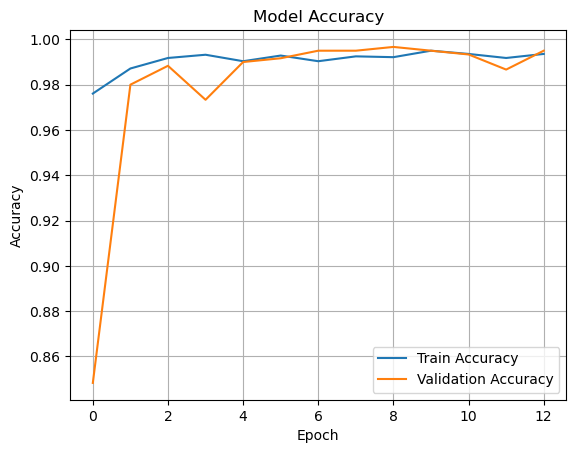

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.grid(True)
plt.show()


<h1>STEP_07:SAVING MODEL, Integrating our model into Gradio & DEPLOYMENT PROCESS </h1>
<h6>I know it doesn't mentioned on the pdf, still its looks like a dead body so i implemented it.</h6>


In [8]:
# Save the trained model
model.save("model.h5")
import pickle
# Save label encoder
with open("label_encoder.pkl", "wb") as f:
     pickle.dump(label_encoder, f)

print("✅ Model and label encoder saved!")


✅ Model and label encoder saved!


In [9]:
import gradio as gr
from tensorflow.keras.models import load_model
import numpy as np
import librosa
import pickle

# Load saved assets
model = load_model("model.h5")

with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

SAMPLE_RATE = 22050
DURATION = 5
SAMPLES_PER_CLIP = SAMPLE_RATE * DURATION
N_MFCC = 13

def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    if len(audio) < SAMPLES_PER_CLIP:
        padding = SAMPLES_PER_CLIP - len(audio)
        audio = np.pad(audio, (0, padding), mode='constant')
    else:
        audio = audio[:SAMPLES_PER_CLIP]
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)
    mfcc_scaled = np.mean(mfcc.T, axis=0)
    return mfcc_scaled

def predict(audio_file):
    features = extract_features(audio_file)
    features = features.reshape(1, N_MFCC, 1)
    prediction = model.predict(features)[0][0]
    label_index = int(prediction > 0.5)  # sigmoid threshold
    label = label_encoder.inverse_transform([label_index])[0]
    confidence = prediction if label_index == 1 else 1 - prediction
    return f"Prediction: {label} ({confidence*100:.2f}% confidence)"

# Gradio UI
demo = gr.Interface(
    fn=predict,
    inputs=gr.Audio(type="filepath", label="Upload .wav file"),
    outputs="text",
    title="🐝 Queen Bee Presence Detection",
    description="Upload a .wav audio from a beehive. The model will predict if a Queen Bee is present."
)

demo.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


<h1>THANKYOU!!!!!!!!!!!!</h1
>